In [1]:
%load_ext autoreload

# *Learning Redundancy in Supply Chain Networks: Analysis of Topological and Structural Signals*

**Goal**: Calculate and predict *real* supply chain redundancy. Comparing the use of structural metrics vs using topological metrics vs using both metrics during learning. 

**Motivation**: There is a problem of the problem with the *illusion* of redundancy in supply chain networks. Supply chain audits rely on degree, number of suppliers, number of routes, but these fail to detect shared failure modes, meaning that "redundant" edges or nodes may not be redundant at all.

**Structural Metrics:** Quantify local geometry and path-based properties of the graph. These metrics are typically sensitive to degrees, distances, and flow-like behavior, but do not explicitly encode higher-order connectivity.
- Degree change: Measures whether removal of X locally alters node connectivity.
- Shortest-path distortion: Captures whether alternative routes preserve path efficiency.
- Edge / node betweenness change: Measures whether traffic or flow is re-routed through different parts of the network after removal.
- Local efficiency: Quantifies robustness of information exchange in the neighborhood.
- Spectral stability: Measures sensitivity of the graph Laplacian spectrum to removal.

**Topological Metrics:** Quantify higher-order connectivity and redundancy of paths, capturing global structural features that persist across scales. Initial idea is that topological redundancy reflects whether X participates in persistent alternative structures rather than merely short local detours.
- Connected components (0-dimensional homology): Detects whether removal disconnects the graph.
- Cycle persistence (1-dimensional homology): Measures destruction of cycles that encode alternative pathways.
- Total persistence: Captures how much “redundancy mass” is lost.
- Loop stability across filtrations: Evaluates whether cycles persist under multiple edge-weight or distance filtrations.

---

# *Defining Redundancy of a Supply Chain Route*

### What is Route/Edge Redundancy?

**In general:** Let X be an edge or set of connected edges. Remove X from G to produce new graph G\X. X is redundant if change between G and G\X is negligible under a chosen family of structural and topological metrics.

**In a Supply Chain Network:** Let X be an edge or set of connected edges. Remove X from G to produce new graph G\X. X is redundant if the removal of X causes only negligible impact on the network’s ability to deliver materials or products to all nodes. More concretely, X is redundant if:
- Reachability is largely preserved: Most or all nodes can still be reached from their sources after removing X
- Delivery efficiency is minimally affected: The time, distance, or cost required to move products through the network changes only slightly for the nodes that remain reachable.

In other words, redundancy measures whether X participates in critical pathways or whether alternative routes and structures exist that allow the supply chain to function effectively even in its absence. 

### Creating a Redundancy Score for any X

With those definitions in mind, we will define a set of edges \(X\)'s *redundancy score* as:
$$
R(X) = 
\sum_{v \in V_{\text{reachable}}} \big( t_{G \setminus X}(v) - t_G(v) \big) 
+ \lambda \cdot |V_{\text{unreachable}}|
$$

where:  

- $V_{\text{reachable}}$ is the set of nodes still reachable after removing $X$,  
- $V_{\text{unreachable}}$ is the set of nodes that can no longer be reached,  
- $t_G(v)$ is the time (or number of weighted steps) it takes for node $v$ to receive material in the original graph $G$,  
- $t_{G \setminus X}(v)$ is the corresponding time in the modified graph $G \setminus X$,  
- $\lambda$ is a large (and negative) penalty weight for unreachable nodes. Large because unreachable nodes should dominate delay.

The greater the redundancy score $R(X)$, the more redundant $X$ is and vice versa.


---
# *Creating a Redundancy Scorer*

### Reducing Complexity of Computing the Score

Computing $R(X)$ exactly for every candidate removal $X$ during training can be expensive (we would be recomputing a diffusion or flow simulation per $X$). We can instead approximate $R(X)$ using diffusion and the heat equation:

- Model diffusion by the heat equation on the graph Laplacian $L$. Start from an initial source signal $f(0)$ (e.g., supply injection at source nodes). The diffusion at time $t$ is $ f(t) = e^{-tL} f(0) $

- Define the arrival time of node $v$ in graph $G$ as the first time its diffused mass crosses a threshold $\tau$. That is, let $t_G(v) = \min\{ t \ge 0 : f_v(t) \ge \tau \}$. 

- Then the redundancy score is $R(X) = \sum_{v \in V_{\text{reachable}}} \big(t_{G\setminus X}(v) - t_G(v)\big) + \lambda \cdot |V_{\text{unreachable}}|$

To do spectral (fast) approximation, we compute just the top $k$ eigenpairs $(\lambda_i, \phi_i)$ of $L$ (once), and use the truncated heat kernel $e^{-tL} \approx \sum_{i=1}^k e^{-t\lambda_i} \phi_i \phi_i^\top$. When an edge set $X$ is removed, the Laplacian changes by a sparse perturbation $\Delta L$. Use first-order perturbation to update eigenvalues $\tilde\lambda_i \approx \lambda_i + \phi_i^\top (\Delta L) \phi_i$ and recompute the truncated sum with $\tilde\lambda_i$. Arrival times $t_{G\setminus X}(v)$ are then derived from the approximated $f_{G\setminus X}(t)$.

Note that we will consider a node v unreachable if its diffusion signal never crosses the arrival threshold $\tau$ within a maximum time horizon $T_{max}$


### Choice of Diffusion for Redundancy Metric

1. Single vs Multiple Sources? 

   Multiple sources. Most supply chains have several suppliers or warehouses feeding the network simultaneously. Modeling diffusion from multiple sources better captures real-world redundancy and alternative routing.

2. Linear vs Nonlinear Congestion? 

   Linear flow approximation. Assume that the “flow” of material is proportional to edge capacities and additive. Nonlinear congestion (e.g., queueing, bottlenecks) could be modeled in the future, but linear flow keeps computation tractable for large graphs.

3. Steady-state vs Transient Dynamics?  

   Transient dynamics. Measure how long it takes nodes to receive material after removing $X$, rather than just the steady-state distribution. This aligns with our delay-based redundancy score $R(X)$ and captures the temporal fragility of the network.

Note that our $R(X)$ metric is highly dependent on the diffusion model we choose! Future work could involve changing the diffusion choice used.

### Create Redundancy Scorer

In [2]:
import numpy as np
import networkx as nx
from scipy.sparse import csr_matrix, diags
from scipy.sparse.linalg import eigsh
from typing import List, Tuple, Dict, Optional
import warnings


import numpy as np
from scipy.sparse import csr_matrix
from scipy.sparse.linalg import eigsh

def precompute_eigenpairs(G: nx.Graph, k: int, laplacian_kind: str = 'combinatorial', tol_zero=1e-9):
    """
    Compute the smallest k *non-trivial* eigenpairs of the graph Laplacian.

    This function builds the (combinatorial) graph Laplacian L = D - W and
    computes its eigenvalues and eigenvectors. Eigenvalues close to zero
    correspond to connected components and are excluded.

    Parameters
    ----------
    G : nx.Graph
        Undirected, weighted graph.
        Edge weights are assumed to be non-negative and stored under the
        'weight' attribute (default = 1.0 if missing).

    k : int
        Number of *non-zero* Laplacian eigenpairs to return.
        These correspond to the lowest-frequency (smoothest) modes.

    laplacian_kind : str
        Currently unused; reserved for future extension (e.g. normalized Laplacian).

    tol_zero : float
        Numerical threshold below which an eigenvalue is considered zero
        (i.e., part of the nullspace / connected components).

    Returns
    -------
    eigvals : np.ndarray, shape (k,)
        The smallest k non-zero Laplacian eigenvalues.

    eigvecs : np.ndarray, shape (n, k)
        Corresponding eigenvectors, stored column-wise.
        eigvecs[:, i] corresponds to eigvals[i].
    """
    n = G.number_of_nodes()
    if n == 0:
        return np.array([]), np.zeros((0, 0))

    # Build combinatorial Laplacian L = D - W (dense, then to sparse)
    nodes = list(G.nodes())
    idx = {node: i for i, node in enumerate(nodes)}
    W = np.zeros((n, n))
    for u, v, data in G.edges(data=True):
        i, j = idx[u], idx[v]
        w = data.get('weight', 1.0)
        W[i, j] = w
        W[j, i] = w
    D = np.diag(W.sum(axis=1))
    L = D - W
    L_sparse = csr_matrix(L)

    # We will request m eigenpairs from eigsh where m = min(k + n_extra, n - 1)
    # n - 1 ensures eigsh does not get asked to compute all n eigenpairs.
    # Small graphs -> fallback to dense eigh reliably.
    m = min(k + 5, max(1, n - 1))  # request few extra to ensure we can drop near-zero
    try:
        eigvals_all, eigvecs_all = eigsh(L_sparse, k=m, which='SM')  # smallest magnitude
    except Exception:
        # fallback to dense, reliable
        eigvals_all, eigvecs_all = np.linalg.eigh(L)
    # Sort ascending
    order = np.argsort(eigvals_all)
    eigvals_all = eigvals_all[order]
    eigvecs_all = eigvecs_all[:, order]

    # Drop near-zero eigenvalues (trivial components). Keep next k eigenpairs.
    keep_idxs = [i for i, val in enumerate(eigvals_all) if val > tol_zero]
    if len(keep_idxs) < k:
        # If we don't have enough non-zero eigenvalues in the small set,
        # fall back to dense full eigen-decomp (safe for modest n).
        if n <= 2000:  # adjust threshold by your memory
            eigvals_full, eigvecs_full = np.linalg.eigh(L)
            order_full = np.argsort(eigvals_full)
            eigvals_full = eigvals_full[order_full]
            eigvecs_full = eigvecs_full[:, order_full]
            keep_idxs = [i for i, val in enumerate(eigvals_full) if val > tol_zero]
            take = keep_idxs[:k]
            eigvals = eigvals_full[take]
            eigvecs = eigvecs_full[:, take]
            return eigvals, eigvecs
        else:
            # Otherwise, pad with the smallest available non-zero eigenpairs
            # (this is a fallback but will still work numerically)
            take = keep_idxs[:k]
            eigvals = eigvals_all[take]
            eigvecs = eigvecs_all[:, take]
            return eigvals, eigvecs

    # Normal case: take first k non-zero eigenpairs from eigvals_all
    take = keep_idxs[:k]
    eigvals = eigvals_all[take]
    eigvecs = eigvecs_all[:, take]
    return eigvals, eigvecs



def compute_delta_L_for_edges(G: nx.Graph, X: List[Tuple]) -> np.ndarray:
    """
    Compute the change in the Laplacian matrix ΔL caused by removing edges X.

    For a single edge (u, v) with weight w:
        ΔL = -w (e_u - e_v)(e_u - e_v)^T

    For multiple edges, the contributions are summed.

    Parameters
    ----------
    G : nx.Graph
        Original weighted graph.

    X : List[Tuple]
        List of edges to remove, where each edge is given as (u, v).

    Returns
    -------
    delta_L : np.ndarray, shape (n, n)
        Dense matrix representing the change in the Laplacian.
        This matrix is negative semi-definite.
    """
    n = G.number_of_nodes()
    nodes = list(G.nodes())
    node_to_idx = {node: i for i, node in enumerate(nodes)}
    
    delta_L = np.zeros((n, n))
    
    for u, v in X:
        if not G.has_edge(u, v):
            continue  # Edge doesn't exist, skip
        
        i, j = node_to_idx[u], node_to_idx[v]
        weight = G[u][v].get('weight', 1.0)
        
        # Rank-1 update: -w * (e_i - e_j)(e_i - e_j)^T
        diff = np.zeros(n)
        diff[i] = 1.0
        diff[j] = -1.0
        delta_L -= weight * np.outer(diff, diff)
    
    return delta_L


def approx_eigen_updates(phis: np.ndarray, deltaL: np.ndarray) -> np.ndarray:
    """
    Approximate changes to Laplacian eigenvalues using first-order perturbation theory.

    For eigenpair (λ_i, φ_i):
        δλ_i ≈ φ_i^T ΔL φ_i

    Parameters
    ----------
    phis : np.ndarray, shape (n, k)
        Eigenvectors of the original Laplacian.

    deltaL : np.ndarray, shape (n, n)
        Change in Laplacian due to edge removals.

    Returns
    -------
    delta_lambdas : np.ndarray, shape (k,)
        Approximate change to each eigenvalue.
    """
    k = phis.shape[1]
    delta_lambdas = np.zeros(k)
    
    for i in range(k):
        phi_i = phis[:, i]
        # First-order perturbation: δλ_i = φ_i^T ΔL φ_i
        delta_lambdas[i] = phi_i.T @ deltaL @ phi_i
    
    return delta_lambdas

def resolve_eval_nodes(eval_nodes, node_to_idx, n):
    """
    Accept eval_nodes as:
    - None -> returns list(range(n))
    - list of node IDs -> maps to indices using node_to_idx (skips unknown IDs)
    - list of integer indices -> if all in 0..n-1, use directly
    Returns list of indices.
    """
    if eval_nodes is None:
        return list(range(n))
    # try mapping each element; if element is present in node_to_idx, map; else if integer in range, accept
    out = []
    for item in eval_nodes:
        if item in node_to_idx:
            out.append(node_to_idx[item])
        elif isinstance(item, int) and 0 <= item < n:
            out.append(item)
        else:
            # skip unknown id with warning
            warnings.warn(f"Skipping unknown eval node {item}")
    return out


def heat_arrival_times_from_eigs_with_zero(
    eigs: np.ndarray,           # shape (k,) : nonzero eigenvalues (k may be 0)
    phis: np.ndarray,           # shape (n, k)
    f0: np.ndarray,             # shape (n,)
    tau: float,
    t_grid: np.ndarray,
    eval_indices: Optional[List[int]] = None
) -> Dict[int, float]:
    """
    Compute node arrival times using a truncated heat-kernel expansion,
    explicitly including the zero (constant) eigenmode.

    The signal evolution is:
        f(t) = φ₀φ₀ᵀf₀ + Σᵢ exp(-λᵢ t) φᵢφᵢᵀf₀

    Arrival time is defined as the earliest t such that f_v(t) ≥ tau.

    Parameters
    ----------
    eigs : np.ndarray, shape (k,)
        Non-zero Laplacian eigenvalues.

    phis : np.ndarray, shape (n, k)
        Corresponding eigenvectors.

    f0 : np.ndarray, shape (n,)
        Initial signal (typically 1 at sources, 0 elsewhere).

    tau : float
        Threshold defining “arrival”.

    t_grid : np.ndarray
        Discrete time grid.

    eval_indices : list[int] or None
        Node indices to evaluate.

    Returns
    -------
    arrival_times : Dict[int, float]
        Mapping node_index → arrival time.
        np.inf indicates no arrival within the time horizon.
    """
    n = f0.shape[0]
    if eval_indices is None:
        eval_indices = np.arange(n)
    else:
        eval_indices = np.array(eval_indices, dtype=int)

    # zero-mode (constant eigenvector) contribution
    phi0 = np.ones(n) / np.sqrt(n)          # normalized constant eigenvector
    coeff0 = float(phi0 @ f0)               # scalar
    # contribution at any time from zero-mode: phi0 * coeff0 (time-invariant)

    # truncated nonzero modes (may be empty)
    if phis is None or phis.size == 0:
        # only zero-mode contributes
        # steady state value at each node:
        steady = (phi0 * coeff0)[eval_indices]
        arrival = {}
        for idx, node_idx in enumerate(eval_indices):
            val = steady[idx]
            arrival[int(node_idx)] = 0.0 if val >= tau else np.inf
        return arrival

    # compute coefficients for nonzero modes
    coeffs = phis.T @ f0   # shape (k,)

    # phi_eval shape: (n_eval, k)
    phi_eval = phis[eval_indices, :]   # (n_eval, k)

    # Build exp(-t * eigs) matrix: (T, k)
    exp_mat = np.exp(-np.outer(t_grid, eigs))   # (T, k)

    # Weighted contributions: for each t, vector w_t = exp(-t*eigs) * coeffs
    # Then f_nonzero(t) at eval nodes = phi_eval @ w_t.T
    # Do matmul: F_nonzero = exp_mat * coeffs  -> (T, k) elementwise multiply
    F_nonzero = (exp_mat * coeffs[np.newaxis, :]) @ phi_eval.T   # (T, n_eval)

    # Zero-mode steady contribution per eval node:
    steady_zero = (phi0 * coeff0)[eval_indices]   # (n_eval,)

    # Total F over time: F = F_nonzero + steady_zero (broadcast steady_zero along t axis)
    Tlen = len(t_grid)
    # Detect arrival times: first t where F[:, j] + steady_zero[j] >= tau
    arrival_times = {}
    # We'll vectorize detection
    F_total = F_nonzero + steady_zero[np.newaxis, :]   # (T, n_eval)

    # For numerical robustness, treat small negatives as zeros
    # Now find first index per column where >= tau
    reached_mask = F_total >= tau   # (T, n_eval)
    # For columns where any True, argmax returns first True, else 0 - we need to detect no-True
    any_reached = reached_mask.any(axis=0)   # (n_eval,)
    first_idx = np.argmax(reached_mask, axis=0)   # (n_eval,)
    for pos, node_idx in enumerate(eval_indices):
        if any_reached[pos]:
            arrival_times[int(node_idx)] = float(t_grid[first_idx[pos]])
        else:
            arrival_times[int(node_idx)] = np.inf

    return arrival_times

def nodes_reachable_after_removal(G: nx.Graph, sources: List, X: List[Tuple]) -> set:
    """
    Compute which nodes remain graph-theoretically reachable from any source
    after removing edges X. Uses a copy of G with edges removed and then a 
    multi-source BFS via components.

    Parameters
    ----------
    G : nx.Graph
        Original graph.

    sources : list
        Source node IDs.

    X : list[tuple]
        Edges to remove.

    Returns
    -------
    reachable : set
        Set of node IDs reachable from at least one source in G \\ X.
    """
    G_removed = G.copy()
    for (u, v) in X:
        if G_removed.has_edge(u, v):
            G_removed.remove_edge(u, v)
    reachable = set()
    for s in sources:
        if s in G_removed:
            # add the entire connected component of s
            try:
                comp = nx.node_connected_component(G_removed, s)
            except Exception:
                # fallback: single_source_shortest_path_length
                comp = set(nx.single_source_shortest_path_length(G_removed, s).keys())
            reachable.update(comp)
    return reachable


def compute_redundancy_score(
    G: nx.Graph,
    sources: List,
    X: List[Tuple],
    params: Optional[Dict] = None
) -> Tuple[float, Dict]:
    """
    Compute a redundancy score for an edge set X by measuring how much
    removing X delays or blocks diffusion from sources.

    The score combines:
    - Total diffusion delay over reachable nodes
    - A penalty proportional to the number of unreachable nodes

    Returns a normalized redundancy score and detailed diagnostics.

    Returns
    -------
    R_norm : float
        Redundancy score in [0, 100], where higher = more redundant.

    diagnostics : Dict
        Contains:
        - 'R_raw' : unnormalized disruption
        - 'R' : normalized disruption
        - 'num_unreachable' : number of unreachable nodes
        - 'total_delay' : sum of delays
        - 'node_delays' : dict {node_index → delay or inf}
        - 'reachable_node_ids_after_removal' : set of node IDs
        - 'method' : string identifier
        - optionally 'eigen_deltas'
    """
    # Default parameters (lambda_penalty positive = disruption cost)
    defaults = {
        'k_eig': 20,
        'tau': 0.1,
        'lambda_penalty': 1000.0,
        'ego_radius': None,
        'eval_nodes': None,
        'return_deltas': False,
        'T_max': 10.0,
        'dt': 0.01
    }
    if params is None:
        params = {}
    params = {**defaults, **params}

    # Node list and mapping
    nodes = list(G.nodes())
    node_to_idx = {node: i for i, node in enumerate(nodes)}
    idx_to_node = {i: node for node, i in node_to_idx.items()}
    n = len(nodes)

    # Build initial signal f0 (vector on node indices)
    f0 = np.zeros(n)
    for s in sources:
        if s in node_to_idx:
            f0[node_to_idx[s]] = 1.0

    # Precompute eigenpairs for original graph (nonzero modes)
    k_eig = min(params['k_eig'], max(1, n - 1))
    lambdas, phis = precompute_eigenpairs(G, k_eig)

    # Time grid
    t_grid = np.arange(0, params['T_max'] + params['dt'], params['dt'])

    # Determine eval nodes (use ego radius if provided, else full graph or params['eval_nodes'])
    if params['eval_nodes'] is None and params['ego_radius'] is not None:
        # compute ego nodes around edges in X
        ego_nodes = set()
        for (u, v) in X:
            if u in G and v in G:
                # nodes within radius r of u and v
                try:
                    du = nx.single_source_shortest_path_length(G, u, cutoff=params['ego_radius'])
                    dv = nx.single_source_shortest_path_length(G, v, cutoff=params['ego_radius'])
                    ego_nodes.update(du.keys())
                    ego_nodes.update(dv.keys())
                except Exception:
                    pass
        eval_nodes_input = list(ego_nodes)
    else:
        eval_nodes_input = params['eval_nodes']  # may be None (interpreted as all)

    # Resolve eval nodes into indices (robust)
    eval_indices = resolve_eval_nodes(eval_nodes_input, node_to_idx, n)

    # Compute baseline arrival times on original G
    arrival_times_G = heat_arrival_times_from_eigs_with_zero(
        lambdas, phis, f0, params['tau'], t_grid, eval_indices
    )

    # Compute reachable nodes after removal of X (using graph connectivity)
    reachable_node_ids = nodes_reachable_after_removal(G, sources, X)

    # Compute ΔL for removed edges (for eigen perturbation)
    delta_L = compute_delta_L_for_edges(G, X)

    # Approximate eigenvalue updates (first order)
    delta_lambdas = approx_eigen_updates(phis, delta_L)
    lambdas_perturbed = lambdas + delta_lambdas
    lambdas_perturbed = np.maximum(lambdas_perturbed, 1e-12)

    # Compute arrival times from spectral approx for G\X (for all eval indices)
    arrival_times_G_X_spec = heat_arrival_times_from_eigs_with_zero(
        lambdas_perturbed, phis, f0, params['tau'], t_grid, eval_indices
    )

    # Now **enforce true reachability**: nodes not in reachable_node_ids are unreachable
    arrival_times_G_X = {}
    for idx in eval_indices:
        node_id = idx_to_node[idx]
        if node_id not in reachable_node_ids:
            arrival_times_G_X[idx] = np.inf
        else:
            # use spectral estimate if available; fallback to inf
            arrival_times_G_X[idx] = arrival_times_G_X_spec.get(idx, np.inf)

    # Compute delays and unreachable count
    node_delays = {}
    num_unreachable = 0
    total_delay = 0.0
    for v_idx in eval_indices:
        t_G = arrival_times_G.get(v_idx, np.inf)
        t_G_X = arrival_times_G_X.get(v_idx, np.inf)

        if np.isinf(t_G_X):
            num_unreachable += 1
            node_delays[v_idx] = np.inf
        else:
            # delay: if original was inf but now reachable, treat delay = t_G_X (or consider as large)
            if np.isinf(t_G):
                delay = t_G_X
            else:
                delay = max(0.0, t_G_X - t_G)
            node_delays[v_idx] = delay
            total_delay += delay

    # Compute raw disruption metric (higher = more disruptive)
    R_raw = total_delay + params['lambda_penalty'] * num_unreachable

    # Normalize into 0..100; note interpretation: higher = more disruptive
    R_max = n * params['T_max'] + params['lambda_penalty'] * n
    if R_max <= 0:
        R_norm = R_raw
    else:
        R_norm = (R_raw / R_max) * 100.0

    # Optionally invert to express "redundancy" (lower disruption -> higher redundancy)
    # Here we return disruption R_norm; if you prefer redundancy in [0,100], do 100 - R_norm.
    diagnostics = {
        'R_raw': R_raw,
        'R': R_norm,
        'num_unreachable': num_unreachable,
        'total_delay': total_delay,
        'node_delays': node_delays,
        'reachable_node_ids_after_removal': reachable_node_ids,
        'method': 'spectral_approximation'
    }
    if params.get('return_deltas', False):
        diagnostics['eigen_deltas'] = delta_lambdas

    # so that higher R_norm = more redundant
    R_norm = 100 - R_norm
    return R_norm, diagnostics



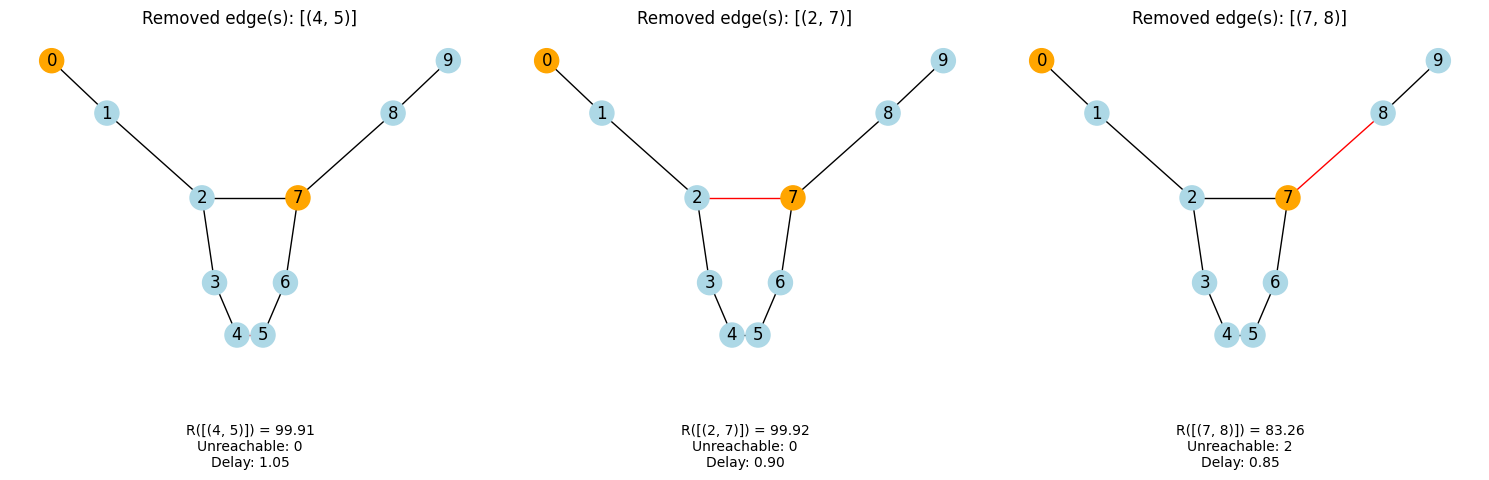

In [3]:
import matplotlib.pyplot as plt
import networkx as nx

#  Graph setup
G_test = nx.Graph()
for i in range(9):
    G_test.add_edge(i, i + 1, weight=1.0)
G_test.add_edge(2, 7, weight=1.0)

sources_test = [0, 7]
fixed_pos = nx.spectral_layout(G_test)

X_set = [[(4, 5)], [(2, 7)], [(7, 8)]]

# Node coloring
def node_colors(G, sources):
    return ['orange' if n in sources else 'lightblue' for n in G.nodes()]

# -Plot
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

for i, X in enumerate(X_set):

    R_bridge, diag_bridge = compute_redundancy_score(
        G_test,
        sources_test,
        X,
        params={'k_eig': 20, 'tau': 0.1, 'lambda_penalty': 100.0, 'T_max': 20.0, 'dt': 0.05}
    )

    # Copy graph
    second_graph = G_test.copy()

    # Edge coloring
    edge_colors = {e: 'black' for e in second_graph.edges()}
    for e in X:
        if second_graph.has_edge(*e):
            edge_colors[e] = 'red'

    edge_color_list = [edge_colors[e] for e in second_graph.edges()]

    # Draw
    nx.draw_networkx(
        second_graph,
        pos=fixed_pos,
        ax=axes[i],
        with_labels=True,
        node_color=node_colors(second_graph, sources_test),
        edge_color=edge_color_list
    )

    axes[i].set_title(f"Removed edge(s): {X}")
    axes[i].axis('off')

    # Metrics under subplot (axis-relative coordinates)
    axes[i].text(
        0.5,
        -0.18,
        f"R({X}) = {R_bridge:.2f}\n"
        f"Unreachable: {diag_bridge['num_unreachable']}\n"
        f"Delay: {diag_bridge['total_delay']:.2f}",
        ha='center',
        va='top',
        fontsize=10,
        transform=axes[i].transAxes
    )

plt.tight_layout()
plt.show()


# *Creating Synthetic Dataset*

### Why Create and Train on Synthetic Data?

R(X), our network metric of interest, is independent of where the data comes from and the information held by the network. We are training to predict a characteristic of a network itself, not something about the information within the network. This, along with the fact that network datasets are hard to find and we need alot to train our GNNs, leads us to create a synthetic dataset rather than trying to obtain one from another source. To make this synthetic dataset, I will use NetworkX's graph generators.

### Important Considerations When Creating the Dataset

Specs are in the README of the `synthetic-graphs` folder

### Dataset Creation using NetworkX

In [ ]:
# reload python script

import sys
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
import torch

sys.path.append(str(Path.cwd()))

from generate_synthetic_dataset import (
    generate_dataset,
    split_dataset,
    CONFIG
)


# Generate the dataset

data_list = generate_dataset(compute_redundancy_score=compute_redundancy_score)

print(f"Generated {len(data_list)} graphs")

if len(data_list) == 0:
    raise RuntimeError("Dataset is empty — aborting save.")

# split dataset

train_data, val_data, test_data = split_dataset(data_list)

print(f"Train: {len(train_data)} | Val: {len(val_data)} | Test: {len(test_data)}")

# create output directory

output_dir = Path(CONFIG["output_dir"])
output_dir.mkdir(parents=True, exist_ok=True)

# save dataset

train_path = output_dir / "train.pt"
val_path   = output_dir / "val.pt"
test_path  = output_dir / "test.pt"

torch.save(train_data, train_path)
torch.save(val_data, val_path)
torch.save(test_data, test_path)

print("Dataset saved successfully:")
print(f"  {train_path} ({len(train_data)} graphs)")
print(f"  {val_path} ({len(val_data)} graphs)")
print(f"  {test_path} ({len(test_data)} graphs)")


Synthetic Dataset Generation

Generating graphs of size 50...


Graphs n=50: 100%|██████████| 3/3 [00:00<00:00,  3.80it/s]



Generating graphs of size 100...


Graphs n=100: 100%|██████████| 3/3 [00:03<00:00,  1.07s/it]



Generating graphs of size 200...


Graphs n=200: 100%|██████████| 3/3 [00:17<00:00,  5.87s/it]



✓ Generated 8 graphs
Train: 5 | Val: 1 | Test: 2

✓ Dataset saved successfully:
  synthetic-graphs/train.pt (5 graphs)
  synthetic-graphs/val.pt (1 graphs)
  synthetic-graphs/test.pt (2 graphs)

Reloading to verify...
Reload OK — 5 graphs loaded


### Data Exploration

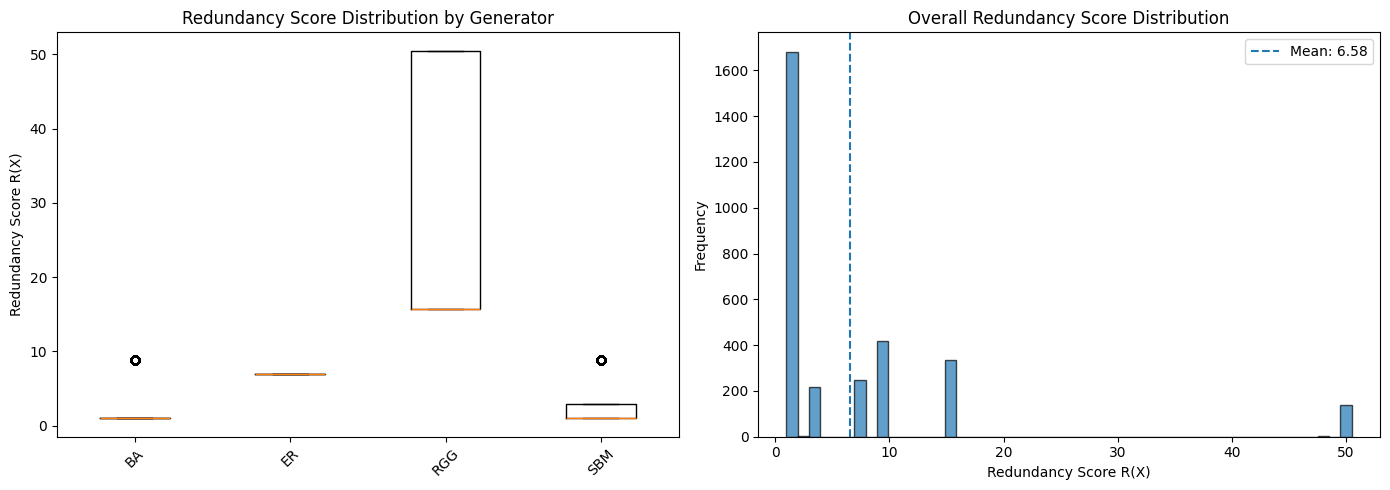

In [9]:
# Plot redundancy score distributions

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Collect redundancy scores by generator
generator_redundancy = {}

for data in data_list:
    gen_type = getattr(data, "generator", "unknown")
    scores = data.y.cpu().numpy().flatten()
    scores = scores[~np.isnan(scores)]

    if len(scores) == 0:
        continue

    generator_redundancy.setdefault(gen_type, []).extend(scores)

# Filter and sort
sorted_items = [
    (gen, scores)
    for gen, scores in sorted(generator_redundancy.items())
    if len(scores) > 0
]

if len(sorted_items) == 0:
    raise RuntimeError("No valid redundancy scores found.")

labels = [gen for gen, _ in sorted_items]
box_data = [scores for _, scores in sorted_items]

# Boxplot by generator
axes[0].boxplot(box_data)
axes[0].set_xticklabels(labels, rotation=45)
axes[0].set_ylabel("Redundancy Score R(X)")
axes[0].set_title("Redundancy Score Distribution by Generator")

# Overall distribution
all_redundancy = np.concatenate(box_data)

axes[1].hist(all_redundancy, bins=50, edgecolor="black", alpha=0.7)
axes[1].set_xlabel("Redundancy Score R(X)")
axes[1].set_ylabel("Frequency")
axes[1].set_title("Overall Redundancy Score Distribution")
axes[1].axvline(
    np.mean(all_redundancy),
    linestyle="--",
    label=f"Mean: {np.mean(all_redundancy):.2f}"
)
axes[1].legend()

plt.tight_layout()
plt.show()

In [12]:
import torch 

train_data = torch.load("synthetic-graphs/train.pt", weights_only=False)
val_data = torch.load("synthetic-graphs/val.pt", weights_only=False)
test_data = torch.load("synthetic-graphs/test.pt", weights_only=False)

graph = train_data[0]
print(graph.x.shape)
print(graph.edge_attr.shape)
print(graph.y.shape)
print(graph.generator)

torch.Size([94, 3])
torch.Size([337, 2])
torch.Size([337, 1])
RGG


# *Training Structure Informed GNN to predict R(X)*

# *Training Topologically Informed GNN to predict R(X)*

# *Training Topologically __and__ Structurally Informed GNN to predict R(X)*

results will tell us about whether topology or structure better encodes redundancy in a network?

# *Testing Models on a Real Supply Chain Dataset*